In [1]:
# https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
# https://www.cnblogs.com/fydeblog/p/9439024.html
# https://github.com/martinarjovsky/WassersteinGAN
# https://github.com/Zeleni9/pytorch-wgan/blob/master/utils/config.py

In [2]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import cv2
import random
import torch
import time as t
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from torchsummary import summary

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [3]:
# Root directory for dataset
dataroot = "E:/condaDev/GAN/dataset/"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 15

# Learning rate for optimizers
lrD = 0.00005
lrG = 0.00005

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

weight_cliping_limit = 0.01

n_extra_layers = 0

experiment = 'WGAN'

Diters = 5

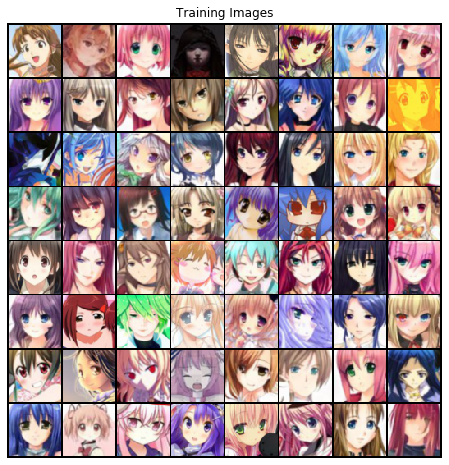

In [4]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [5]:
real_batch[0].shape

torch.Size([128, 3, 64, 64])

In [6]:
real_batch[1].shape

torch.Size([128])

In [7]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [8]:
class DCGAN_G(nn.Module):
    def __init__(self, isize, nz, nc, ngf, ngpu, n_extra_layers=0):
        super(DCGAN_G, self).__init__()
        self.ngpu = ngpu
        assert isize % 16 == 0, "isize has to be a multiple of 16"

        cngf, tisize = ngf//2, 4
        while tisize != isize:
            cngf = cngf * 2
            tisize = tisize * 2

        main = nn.Sequential()
        # input is Z, going into a convolution
        main.add_module('initial:{0}-{1}:convt'.format(nz, cngf),
                        nn.ConvTranspose2d(nz, cngf, 4, 1, 0, bias=False))
        main.add_module('initial:{0}:batchnorm'.format(cngf),
                        nn.BatchNorm2d(cngf))
        main.add_module('initial:{0}:relu'.format(cngf),
                        nn.ReLU(True))

        csize, cndf = 4, cngf
        while csize < isize//2:
            main.add_module('pyramid:{0}-{1}:convt'.format(cngf, cngf//2),
                            nn.ConvTranspose2d(cngf, cngf//2, 4, 2, 1, bias=False))
            main.add_module('pyramid:{0}:batchnorm'.format(cngf//2),
                            nn.BatchNorm2d(cngf//2))
            main.add_module('pyramid:{0}:relu'.format(cngf//2),
                            nn.ReLU(True))
            cngf = cngf // 2
            csize = csize * 2

        # Extra layers
        for t in range(n_extra_layers):
            main.add_module('extra-layers-{0}:{1}:conv'.format(t, cngf),
                            nn.Conv2d(cngf, cngf, 3, 1, 1, bias=False))
            main.add_module('extra-layers-{0}:{1}:batchnorm'.format(t, cngf),
                            nn.BatchNorm2d(cngf))
            main.add_module('extra-layers-{0}:{1}:relu'.format(t, cngf),
                            nn.ReLU(True))

        main.add_module('final:{0}-{1}:convt'.format(cngf, nc),
                        nn.ConvTranspose2d(cngf, nc, 4, 2, 1, bias=False))
        main.add_module('final:{0}:tanh'.format(nc),
                        nn.Tanh())
        self.main = main

    def forward(self, input):
        if isinstance(input.data, torch.cuda.FloatTensor) and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else: 
            output = self.main(input)
        return output 

In [9]:
# Create the generator
netG = DCGAN_G(image_size, nz, nc, ngf, ngpu, n_extra_layers).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

DCGAN_G(
  (main): Sequential(
    (initial:100-512:convt): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (initial:512:batchnorm): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (initial:512:relu): ReLU(inplace=True)
    (pyramid:512-256:convt): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (pyramid:256:batchnorm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pyramid:256:relu): ReLU(inplace=True)
    (pyramid:256-128:convt): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (pyramid:128:batchnorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pyramid:128:relu): ReLU(inplace=True)
    (pyramid:128-64:convt): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (pyramid:64:batchnorm): BatchNorm2d(64, eps=1e-05, m

In [10]:
netG(torch.randn(128, 100, 1, 1, device=device)).shape

torch.Size([128, 3, 64, 64])

In [11]:
class DCGAN_D(nn.Module):
    def __init__(self, isize, nz, nc, ndf, ngpu, n_extra_layers=0):
        super(DCGAN_D, self).__init__()
        self.ngpu = ngpu
        assert isize % 16 == 0, "isize has to be a multiple of 16"

        main = nn.Sequential()
        # input is nc x isize x isize
        main.add_module('initial:{0}-{1}:conv'.format(nc, ndf),
                        nn.Conv2d(nc, ndf, 4, 2, 1, bias=False))
        main.add_module('initial:{0}:relu'.format(ndf),
                        nn.LeakyReLU(0.2, inplace=True))
        csize, cndf = isize / 2, ndf

        # Extra layers
        for t in range(n_extra_layers):
            main.add_module('extra-layers-{0}:{1}:conv'.format(t, cndf),
                            nn.Conv2d(cndf, cndf, 3, 1, 1, bias=False))
            main.add_module('extra-layers-{0}:{1}:batchnorm'.format(t, cndf),
                            nn.BatchNorm2d(cndf))
            main.add_module('extra-layers-{0}:{1}:relu'.format(t, cndf),
                            nn.LeakyReLU(0.2, inplace=True))

        while csize > 4:
            in_feat = cndf
            out_feat = cndf * 2
            main.add_module('pyramid:{0}-{1}:conv'.format(in_feat, out_feat),
                            nn.Conv2d(in_feat, out_feat, 4, 2, 1, bias=False))
            main.add_module('pyramid:{0}:batchnorm'.format(out_feat),
                            nn.BatchNorm2d(out_feat))
            main.add_module('pyramid:{0}:relu'.format(out_feat),
                            nn.LeakyReLU(0.2, inplace=True))
            cndf = cndf * 2
            csize = csize / 2

        # state size. K x 4 x 4
        main.add_module('final:{0}-{1}:conv'.format(cndf, 1),
                        nn.Conv2d(cndf, 1, 4, 1, 0, bias=False))
        self.main = main


    def forward(self, input):
        if isinstance(input.data, torch.cuda.FloatTensor) and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else: 
            output = self.main(input)
            
        output = output.mean(0)
        return output.view(1)

In [12]:
# Create the Discriminator
netD = DCGAN_D(image_size, nz, nc, ndf, ngpu, n_extra_layers).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

DCGAN_D(
  (main): Sequential(
    (initial:3-64:conv): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (initial:64:relu): LeakyReLU(negative_slope=0.2, inplace=True)
    (pyramid:64-128:conv): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (pyramid:128:batchnorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pyramid:128:relu): LeakyReLU(negative_slope=0.2, inplace=True)
    (pyramid:128-256:conv): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (pyramid:256:batchnorm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pyramid:256:relu): LeakyReLU(negative_slope=0.2, inplace=True)
    (pyramid:256-512:conv): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (pyramid:512:batchnorm): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pyramid

In [13]:
summary(netD, input_size=(3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           3,072
         LeakyReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3          [-1, 128, 16, 16]         131,072
       BatchNorm2d-4          [-1, 128, 16, 16]             256
         LeakyReLU-5          [-1, 128, 16, 16]               0
            Conv2d-6            [-1, 256, 8, 8]         524,288
       BatchNorm2d-7            [-1, 256, 8, 8]             512
         LeakyReLU-8            [-1, 256, 8, 8]               0
            Conv2d-9            [-1, 512, 4, 4]       2,097,152
      BatchNorm2d-10            [-1, 512, 4, 4]           1,024
        LeakyReLU-11            [-1, 512, 4, 4]               0
           Conv2d-12              [-1, 1, 1, 1]           8,192
Total params: 2,765,568
Trainable params: 2,765,568
Non-trainable params: 0
---------------------------

In [14]:
# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)
critic_iter = 5
# Setup RMSprop optimizers for both G and D
optimizerD = optim.RMSprop(netD.parameters(), lr=lrD)
optimizerG = optim.RMSprop(netG.parameters(), lr=lrG)

In [15]:
fixed_noise = torch.FloatTensor(batch_size, nz, 1, 1).normal_(0, 1).to(device)
one = torch.FloatTensor([1]).to(device)
mone = one * -1

In [16]:
def get_infinite_batches(data_loader):
    while True:
        for i, (images, _) in enumerate(data_loader):
            yield images

In [17]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

data = get_infinite_batches(dataloader)

for epoch in range(num_epochs):
        i = 0
        while i < len(dataloader):
            
            for p in netD.parameters():
                p.requires_grad = True
                
            # Train Dicriminator forward-loss-backward-update self.critic_iter times while 1 Generator forward-loss-backward-update
            for d_iter in range(critic_iter):
                netD.zero_grad()
                
                # Clamp parameters to a range [-c, c]
                for p in netD.parameters():
                    p.data.clamp_(-weight_cliping_limit, weight_cliping_limit)
                    
                images = data.__next__()
                b_size = images.size(0)
                
                images = images.to(device)
                
                # Train discriminator
                # WGAN - Training discriminator more iterations than generator
                # Train with real images
                d_loss_real = netD(images)
                d_loss_real = d_loss_real.mean(0).view(1)
                d_loss_real.backward(one)
                
                # Train with fake images
                z = torch.randn(b_size, nz, 1, 1).to(device)
                fake_images = netG(z)
                d_loss_fake = netD(fake_images)
                d_loss_fake = d_loss_fake.mean(0).view(1)
                d_loss_fake.backward(mone)
                
                d_loss = d_loss_fake - d_loss_real
                Wasserstein_D = d_loss_real - d_loss_fake
                optimizerD.step()
                
                i += 1
                
            # Generator update
            for p in netD.parameters():
                p.requires_grad = False  # to avoid computation
                
            netG.zero_grad()
            
            # Train generator
            # Compute loss with fake images
            z = torch.randn(batch_size, nz, 1, 1).to(device)
            fake_images = netG(z)
            g_loss = netD(fake_images)
            g_loss = g_loss.mean().mean(0).view(1)
            g_loss.backward(one)
            g_cost = -g_loss
            optimizerG.step()
            
            if i % 50 == 0:
                print('[%d/%d][%d/%d] Loss_D: %f Loss_G: %f Loss_D_real: %f Loss_D_fake %f'
                    % (epoch, num_epochs, i, len(dataloader),
                    d_loss.data[0], g_loss.data[0], d_loss_real.data[0], d_loss_fake.data[0]))
            
            # Save Losses for plotting later
            G_losses.append(g_loss.item())
            D_losses.append(d_loss.item())
            
            # Check how the generator is doing by saving G's output on fixed_noise
            if (iters % 50 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
                stateG = {'generate':netG.state_dict()}
                stateD = {'discriminator':netD.state_dict()}
                torch.save(stateG, os.path.join(os.getcwd(), "generate.pth"))
                torch.save(stateD, os.path.join(os.getcwd(), "discriminator.pth"))

                with torch.no_grad():
                    fake = netG(fixed_noise).detach().cpu()
                generatedImg = vutils.make_grid(fake, padding=2, normalize=True)
                img_list.append(generatedImg)
                generatedImg = generatedImg.permute(1,2,0).numpy()
                img_save_path = os.path.join(os.getcwd(),"img/{}_{}_{}.png".format(iters, epoch, i))
                image = (generatedImg * 255).round().astype(np.uint8)
                cv2.imwrite(img_save_path, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
                
            iters += 1

[14/15][50/549] Loss_D: 1.198377 Loss_G: 0.594613 Loss_D_real: -0.619154 Loss_D_fake 0.579223
[14/15][100/549] Loss_D: 0.743750 Loss_G: 0.642391 Loss_D_real: -0.687337 Loss_D_fake 0.056413
[14/15][150/549] Loss_D: 1.146510 Loss_G: 0.472868 Loss_D_real: -0.523703 Loss_D_fake 0.622807
[14/15][200/549] Loss_D: 1.190305 Loss_G: 0.608574 Loss_D_real: -0.652575 Loss_D_fake 0.537730
[14/15][250/549] Loss_D: 0.834811 Loss_G: 0.644240 Loss_D_real: -0.673965 Loss_D_fake 0.160846
[14/15][300/549] Loss_D: 1.120860 Loss_G: 0.408651 Loss_D_real: -0.501636 Loss_D_fake 0.619224
[14/15][350/549] Loss_D: 0.965193 Loss_G: 0.168302 Loss_D_real: -0.360496 Loss_D_fake 0.604697
[14/15][400/549] Loss_D: 1.174424 Loss_G: 0.611356 Loss_D_real: -0.648882 Loss_D_fake 0.525542
[14/15][450/549] Loss_D: 1.072031 Loss_G: 0.606725 Loss_D_real: -0.667543 Loss_D_fake 0.404487
[14/15][500/549] Loss_D: 1.171614 Loss_G: 0.606762 Loss_D_real: -0.636130 Loss_D_fake 0.535484
[14/15][550/549] Loss_D: 1.187835 Loss_G: 0.597362 

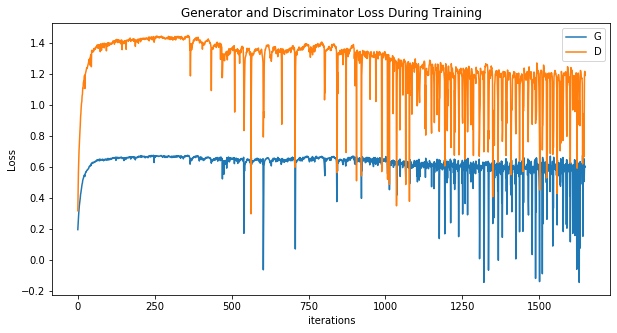

In [18]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

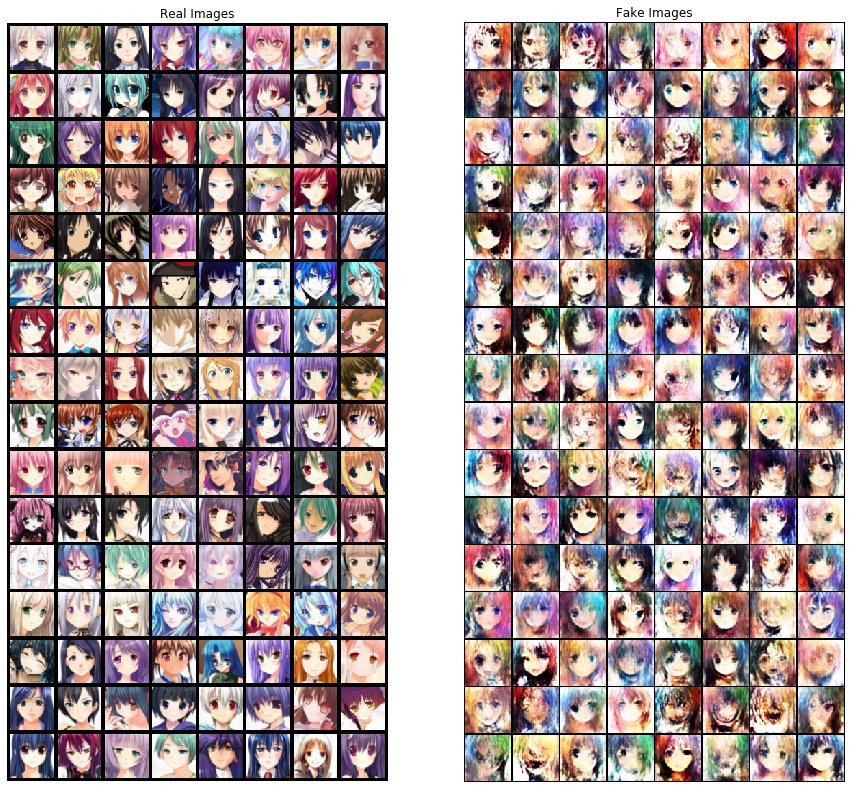

In [21]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:128], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()